In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt 
from datetime import datetime,timedelta

## Reflect Tables into SQLAlchemy ORM

In [4]:
 # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Numeric, Text, Float,Table,ForeignKey
from flask import jsonify

In [5]:
 engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
 # We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

-Design a query to retrieve the last 12 months of precipitation data and   plot the results
-Calculate the date 1 year ago from today
-Perform a query to retrieve the data and precipitation scores
-Save the query results as a Pandas DataFrame and set the index to the  date column
-Sort the dataframe by date
-Use Pandas Plotting with Matplotlib to plot the data
-Rotate the xticks for the dates

In [10]:
# we neeed to know what or when the very last entry was made-
last_entry_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_entry_date)

('2017-08-23',)


In [11]:
# Calculate the date 1 year ago from the last entry
last_year= dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [12]:
# query to pull the last year of precipitation data
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

In [13]:

# Load the data from the query into a dataframe
precipitation_df = pd.DataFrame(precipitation)
precipitation_df.head()

# reset the index to the date

precipitation_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<IPython.core.display.Javascript object>


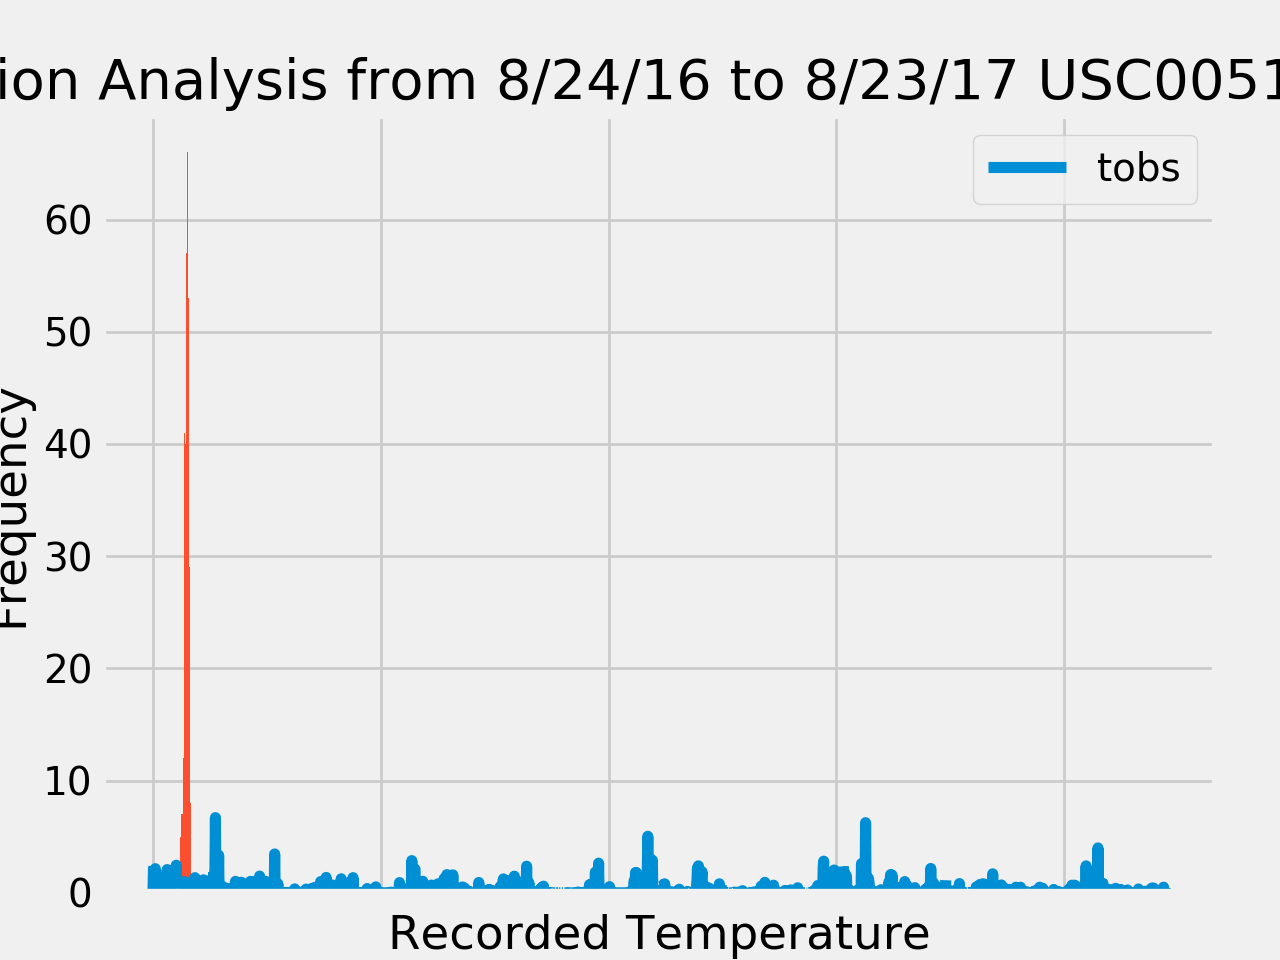

In [14]:
# plot the dataframe

precipitation_df.plot('date', 'prcp')
plt.xlabel(["Sept", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"])
plt.ylabel("precipitation in Inches")
plt.title("Precipitation between (8/24/16 and 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [15]:
# Use Pandas to print the summary statistics for the precipitation data.describe
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# How many stations are available in this dataset?
stat = session.query(Measurement).group_by(Measurement.station).count()
print("{} stations.".format(stat))

9 stations.


In [29]:
# What are the most active stations?
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
# List the stations and the counts in descending order.


for station, count in active_station:
    print(station ,count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [30]:
most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
most_active

'USC00519281'

In [31]:
# highest temperature recorded, and average temperature most active station?
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active).\
                                filter(Measurement.date >= last_year).\
                                order_by(Measurement.date.desc()).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()


,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


In [34]:
plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Freq")
plt.title("Station Analysis from 8/24/16 to 8/23/17 " + most_active)
plt.legend(["tobs"])
plt.show()

In [35]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-02-2', '2017-03-05'))



[(61.0, 70.5813953488372, 78.0)]


<IPython.core.display.Javascript object>


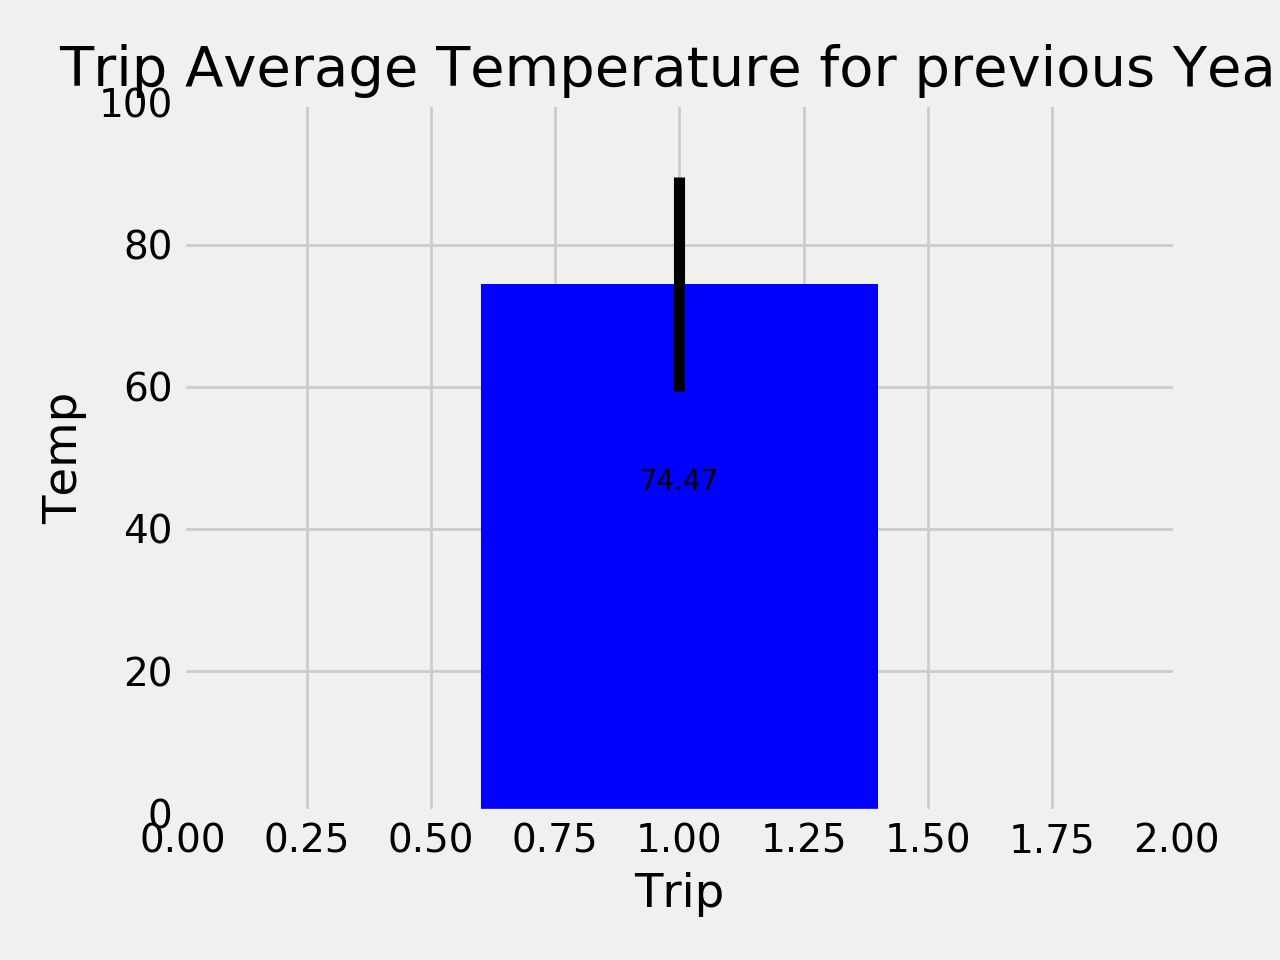

In [59]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'blue', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temp")
ax.set_title("Trip Average Temperature for previous Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()